## Download dati
e altre variabili

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from os import remove, path


# sono i modelli per i quali ho preparato la GridSearch
all_models = ["svm_reg", "tree_reg", "knn_reg", "xgb_reg", "catbst_reg", "lgbm_reg",
                    "svm_cls", "tree_cls", "knn_cls", "xgb_cls", "catbst_cls", "lgbm_cls", "logreg_cls"
                    ]
usually_best_models = ["tree_reg", "xgb_reg", "knn_reg",
                    "tree_cls", "xgb_cls", "knn_cls"
                    ]


# aumentando 'regolarzn' con valori tra 0 e 2 aumenta la regolarizzazione
# dei vari modelli nelle pipeline
regolarzn = 2
# 'available_models' è un riassunto di 'all_models' che serve a fare risparmiare 
# un po di tempo nell' addestramento
available_models = all_models
# numero di prove da fare con i modelli di sklearn
num_experiments_skl_models = 5
# rimuovo eventuali vecchi file
data_file_path = "data/dataset.xlsx"
if path.exists(data_file_path):
  remove("/content/" + data_file_path )

# scarico dal mio google drive
# il file excell con le valutazioni delle lesioni
gdd.download_file_from_google_drive(
    file_id='1RbbBUQycR44bq8ROqlxAskDP4lwSN1_a',
    dest_path=data_file_path 
    )

## Import vari

In [2]:
!pip install --quiet catboost lightgbm tabnet[cpu]

In [3]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, precision_recall_curve, auc 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.exceptions import ConvergenceWarning

# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import Perceptron, LogisticRegression
# from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import InstanceHardnessThreshold

from catboost import CatBoostClassifier, CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor, LGBMClassifier

from mlxtend.classifier import EnsembleVoteClassifier

import random
from functools import reduce 

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
np.warnings.filterwarnings('ignore', category=RuntimeWarning) # DA FARE ATTENZIONE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Funzioni per preparare i dati

### Caricamento dati

In [4]:
def load_xcell_in_dataframe(get_only_pairs = True):
  # carico i dati dal file excell dentro a 3 dataframe
  # divisi per 'operatore' che ha fatto la valutazione e l'esame che è stato valutato
  coronarografia_op1_full = pd.read_excel("/content/data/dataset.xlsx", "Foglio1", usecols = "B:X" )
  coronarografia_op2_full = pd.read_excel("/content/data/dataset.xlsx", "Foglio1", usecols = "Z:AV", names = coronarografia_op1_full.columns)
  taccoronarica_op1_full = pd.read_excel("/content/data/dataset.xlsx", "Foglio1", usecols = "AX:BT", names = coronarografia_op1_full.columns)
  taccoronarica_op2_full = pd.read_excel("/content/data/dataset.xlsx", "Foglio1", usecols = "BV:CR", names = coronarografia_op1_full.columns)

  # ci sono alcuni dati che mancano perche alcuni pazienti hanno
  # fatto la tac per valutare 'il calcio' e non è possibile osservare le stenosi in questi casi 
  coro_op1 = coronarografia_op1_full.convert_dtypes(convert_integer=True)
  coro_op2 = coronarografia_op2_full.convert_dtypes(convert_integer=True)
  tac_op1 = taccoronarica_op1_full.convert_dtypes(convert_integer=True)
  tac_op2 = taccoronarica_op2_full.convert_dtypes(convert_integer=True)

  # rinomino
  coro_op1.rename(columns={"RAMO_INTERMEDIO":"I_INTERMEDIO"}, inplace=True)
  coro_op2.rename(columns={"RAMO_INTERMEDIO":"I_INTERMEDIO"}, inplace=True)
  tac_op1.rename(columns={"RAMO_INTERMEDIO":"I_INTERMEDIO"}, inplace=True)
  tac_op2.rename(columns={"RAMO_INTERMEDIO":"I_INTERMEDIO"}, inplace=True)

  # check correttezza
  assert coro_op1.shape == coro_op2.shape and coro_op2.shape == tac_op2.shape and tac_op2.shape == tac_op1.shape


  if not get_only_pairs:
    return tac_op1, tac_op2, coro_op1, coro_op2
  else:
    # calcolo una lista di tutti gli indici con dei buchi, per poterli filtrare
    indices_with_na = set(list(reduce(
      lambda lista, indici: lista + list(indici),
      map(
          lambda df:df[df.isna().any(axis=1)].index,
          [coro_op1, coro_op2, tac_op1, tac_op2]
      ),
      []
    )))

    indices_without_na = set(list(taccoronarica_op2_full.index)) - indices_with_na

    # filtro i dati per i pazienti(righe) che sono presenti in tutti e tre gli operatori
    coro_op1 = coro_op1[coro_op1.index.isin(indices_without_na)]
    coro_op2 = coro_op2[coro_op2.index.isin(indices_without_na)]
    tac_op1  = tac_op1[ tac_op1.index.isin(indices_without_na)]
    tac_op2  = tac_op2[ tac_op2.index.isin(indices_without_na)]


    return tac_op1, tac_op2, coro_op1, coro_op2



### Preparazione Dati

In [5]:
def get_x_y_from_dataset(tac_op2, coro_op1, coro_op2, trucchetto_per_aumentare_i_dati = False):
  """
  il trucchetto per aumentare i dati mi è stato sconsigliato da tutti perche sbagliato dal punto di vista delle ricerca clinica
  ma credo di averne molto bisogno quindi lo uso
  
  come funzione: sostanzialmente alcune delle letture fatte sulle coronarografie risultano diverse tra i due operatori,
  sfutto questo fatto perche un terzo operatore leggerebbe le due valutezioni diverse come due cuori diversi di due persone diverse ed 
  aggiungo alle X le stesse tac che sono associate a coronarografie con letture diverse, entrambe le coronarigrafie vengono messe tra le Y
  """
  X = np.array([[0]*tac_op2.shape[1]])
  y = np.array([[0]*coro_op1.shape[1]])
  for i in range( coro_op1.shape[0]):
    c1 = np.array(coro_op1.iloc[i])
    c2 = np.array(coro_op2.iloc[i])
    t2 = np.array(tac_op2.iloc[i])
    
    X = np.append(X,np.array([t2]), axis = 0)
    y = np.append(y,np.array([c1]), axis = 0)
    
    if trucchetto_per_aumentare_i_dati:
      diff = np.abs(np.array(c1-c2))    
      
      if diff.sum() > 0:
        X = np.append(X, np.array([t2]), axis = 0)
        y = np.append(y, np.array([c2]), axis = 0)
  return X[1:], y[1:]


In [6]:
def prepare_data_for_model(tac_op2, coro_op1, coro_op2, 
                           column_filter:list = None,
                           model_name:str="tree_cls",
                           usa_trucchetto = False,
                           cosa_cercare:int = 0):
  """
  sostanzialmente ho deciso di predirre se con una coronarografia (invasiva) i pazienti sarebbero mandati all operazione
  se riesco a capire da una tac che la coronarografia non li manderebbe all operazione, posso risparmiare alle persone la coronarografia
  
  una stenosi è do perare quando l'otturazione è superiore al 50%, nel caso del mio dataset 
  le stenosi sono categorizzate da 1 a 6:
  1 -> 0% (tutto ok)
  4 -> 50-69%
  6 -> 100% (ischemia)

  cosa_cercare può essere:
  0 - normale classificazione 
  1 - cerca i falsi negativi
  2 - cerca quelle istanze che sono identiche ma che vengono classificate diversamente 
  """
  assert model_name in available_models 


  if not column_filter:
    X,y = get_x_y_from_dataset(tac_op2, coro_op1, coro_op2, usa_trucchetto)
  else:
    X,y = get_x_y_from_dataset(
        tac_op2[column_filter],
        coro_op1[column_filter],
        coro_op2[column_filter],
        usa_trucchetto)

  _y = []
  for t,c in zip(X, y):
    t_operare = t[0] >= 4 or any(t >= 5)
    c_operare = c[0] >= 4 or any(c >= 5)
    

    condizione_classificazione = {
        0: not t_operare or not c_operare,
        1: t_operare and not c_operare,
        2: (t_operare != c_operare) and (np.all((t - c) == 0)),
        3: t_operare
    }[cosa_cercare]


    if condizione_classificazione:
      _y.append( 1 )
    else:
      _y.append( -1 )

  if model_name == "xgboost":
    _y = convert_y_for_xgboost(_y)
    
  return X.astype(np.int), np.array(_y).astype(np.int)


def convert_y_for_xgboost(y):
  return np.array(
      list(
          map( lambda yi:0 if yi == -1 else 1, y )
      )
  )

In [7]:
def plot_data(X, y):
  """
  stampa qualche informazione basilare su i dati
  """

  y = convert_y_for_xgboost(y)
  pd.DataFrame(np.bincount(X.ravel())).plot.bar(
      title = "Distribuzione delle gravita delle stenosi"
    )

  pd.DataFrame(np.bincount(y.ravel())).plot.bar(
      title = "Distribuzione della necessita di operazioni",
      xlabel = "1 = da NON operare"
    )

In [8]:
def split_data(X,y, test_size = 1/4):
  """
  separa i dati in train e test (nel caso si addestri 'xgboost' imposta l'etichetta delle classi correttamente)
  inoltre, ritorna anche i delle _semplici_ predizioni fatte solo sulla base della TAC, per simulare le decisioni COME sono prese attualmente
  """
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y)
  X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train).ravel(), np.array(y_test).ravel()
  return (X_train, X_test),(y_train, y_test)

In [9]:
def get_split_data(test_size = 1/4, trucchetto = False, filtro_colonne = True):
  """
  Raggruppa un po tutte le funzioni dichiarate sopra
  per ottenere in una chiamata sola X e Y gia divisi per test e train
  """
  relevant_columns = ['TC',
                    'IVA_PROX', 'IVA_MEDIA',
                    'CDX_PROX', 'CDX_MEDIO',
                    'CFX_PROX', 'CFX_MEDIA', 'I_MARGINALE'
                    ]

  tac_op1, tac_op2, coro_op1, coro_op2 = load_xcell_in_dataframe() # >TODO< da sistemare per sfruttare tutti gli operatori


  # trasformo nel formato che mi interessa (con le classi)
  X, y = prepare_data_for_model(
      tac_op1, coro_op1, coro_op2,
      column_filter=relevant_columns if filtro_colonne else None ,
      usa_trucchetto=trucchetto
  )
  # divido TUTTE le vole i dati in maniera random
  Xs, ys = split_data(X,y, test_size)
  return Xs, ys


## Funzioni per addestrare il modello

### Griglie e Pipeline

In [10]:
# Qui c'è solo la dichiarazione di tutte le grid search 
# ogni funzione è nominata come "get_<modello>_<obiettivo>_pipeline_and_grid"

def get_svm_reg_pipeline_and_grid():
  model = Pipeline([
    ("resampl1", None),
    ("preproc1", None),
    ("preproc2", None), #  = 2)
    ("regressor", SVR()),
  ])

  grid =[
    {
      "preproc1": [MinMaxScaler(), StandardScaler()],    
      "regressor__C": [0.01, 0.1, 1, 10],
      "regressor__kernel" : ["rbf", "sigmoid"]
    },
    {
      "resampl1": [SVMSMOTE()],                   
      "preproc1": [MinMaxScaler(), StandardScaler()],        
      "regressor__kernel": ['poly'],
      "regressor__degree": [2, 3],                
      "regressor__C": [0.1, 1, 10 ]                 
    }
  ]
  return model, grid

def get_tree_reg_pipeline_and_grid():
  model = Pipeline([
    ("resampl1", None),
    ("preproc1", None),
    ("preproc2", None),
    ("regressor", RandomForestRegressor()),
  ])

  grid =[
     {
      "resampl1": [None, SVMSMOTE() ], # 3
      "preproc1": [MinMaxScaler(), StandardScaler()],               
      "preproc2": [None, PolynomialFeatures(degree = 2)],
      "regressor__max_depth" : [25, 20, 15, 10, 7, 4][regolarzn:regolarzn+2],                  
      "regressor__max_features": ["sqrt"]
    }]
  return model, grid

def get_svm_clss_pipeline_and_grid():
  model = Pipeline([
    ("resampl1", None),
    ("preproc1", None),
    ("preproc2", None), # (= 2)
    ("regressor", SVC()),
  ])

  grid =[
    {
      "preproc1": [MinMaxScaler(), StandardScaler()],       
      "regressor__C": [0.01, 0.5, 1, 10],
      "regressor__kernel" : ["rbf"]
    },
    {
      "resampl1": [SVMSMOTE()],                        
      "preproc1": [MinMaxScaler(), StandardScaler()],        
      "regressor__kernel": ['poly'],
      "regressor__degree": [2, 3, 4],                          
      "regressor__C": [10, 1, 0.1, 0.01, 0.005][regolarzn:regolarzn+2]                 
    }
  ]
  return model, grid

def get_knn_reg_pipeline_and_grid():
  model = Pipeline([
    ("resampl1", None),
    ("preproc1", None),
    ("preproc2", None), # (= 2)
    ("regressor", KNeighborsRegressor()),
  ])

  grid =[
    {
      "resampl1": [None, SVMSMOTE() ], 
      "preproc1": [None, StandardScaler()],     
      "preproc2": [None, PolynomialFeatures(degree = 2)],    
      "regressor__n_neighbors": [4, 6, 8, 10, 12, 14][regolarzn:regolarzn+2],
      "regressor__weights":["distance"],
      "regressor__algorithm":["auto", "ball_tree", "brute"],
      "regressor__p":[2, 3]
    }
  ]
  return model, grid

def get_tree_clss_pipeline_and_grid():
  model = Pipeline([
    ("resampl1", None),
    ("preproc1", None),
    ("preproc2", None),
    ("regressor", RandomForestClassifier()),
  ])

  grid =[
    {
      "resampl1": [None, SVMSMOTE() ], # 3
      "preproc1": [MinMaxScaler(), StandardScaler()],               
      "preproc2": [None, PolynomialFeatures(degree = 2)],
      "regressor__max_depth" : [25, 20, 15, 10, 7, 4][regolarzn:regolarzn+2],                   
      "regressor__max_features": ["sqrt"],      
      "regressor__ccp_alpha": [0.0, 0.2]             
    }]
  return model, grid


def get_knn_clss_pipeline_and_grid():
  model = Pipeline([
    ("resampl1", None),
    ("preproc1", None),
    ("preproc2", None), 
    ("regressor", KNeighborsClassifier()),
  ])

  grid =[
    {
      "resampl1": [None, SVMSMOTE() ], # 3
      "preproc1": [None, StandardScaler()],        # 3
      "preproc2": [None, PolynomialFeatures(degree = 2)],         # 2 
      "regressor__n_neighbors": [4, 6, 8, 10, 12, 14][regolarzn:regolarzn+2],
      "regressor__weights":["distance"],
      "regressor__algorithm":["auto", "ball_tree", "brute"],
      "regressor__p":[3]
    }
  ]
  return model, grid

def get_xgboost_clss_pipeline_and_grid():
  model = Pipeline([
    ("preproc", None),
    ("classification", xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss', use_label_encoder=False) )
  ])

  grid = [{
    "preproc":[MinMaxScaler(), StandardScaler()],
    "classification__colsample_bytree": [1],
    "classification__learning_rate": [0.45, 0.65],
    "classification__max_depth": [25, 20, 15, 10][regolarzn:regolarzn+2],
    "classification__n_estimators": [10, 20],
    "classification__alpha":  [ 1, 10, 50, 100, 500][regolarzn:regolarzn+2], 
    "classification__lambda": [ 1, 10, 50, 100, 500][regolarzn:regolarzn+2]
  }]
  return model, grid

def get_xgboost_reg_pipeline_and_grid():
  model = Pipeline([
    ("preproc", None),
    ("preproc2",None),
    ("classification", xgb.XGBRegressor(objective ='reg:squarederror') )
  ])

  grid = [{
    "preproc":[MinMaxScaler(), StandardScaler()],
    "preproc2": [None, PolynomialFeatures(degree=2)],

    "classification__colsample_bytree": [1],
    "classification__learning_rate": [0.45, 0.65],
    "classification__max_depth": [25, 20, 15, 10, 7, 4][regolarzn:regolarzn+2],
    "classification__n_estimators": [10, 20],
    "classification__alpha": [ 1, 10, 50, 100, 500][regolarzn:regolarzn+2],
    "classification__lambda": [ 1, 10, 50, 100, 500][regolarzn:regolarzn+2]
  }]
  return model, grid

def get_catboost_cls_pipeline_and_grid():
  model = Pipeline([
    ("preproc", None),
    ("classification", CatBoostClassifier(verbose=0))
  ])

  grid = [{
    "preproc":[MinMaxScaler(), StandardScaler()],
    "classification__iterations": [2,5,8],
    "classification__learning_rate": [0.1, 0.5, 1],
    "classification__depth": [16, 13, 10, 7, 5][regolarzn:regolarzn+2],
  }]
  return model, grid

def get_catboost_reg_pipeline_and_grid():
  model = Pipeline([
    ("preproc", None),
    ("classification", CatBoostRegressor(verbose=0))
  ])

  grid = [{
    "preproc":[MinMaxScaler(), StandardScaler()],
    "classification__iterations": [2,5,8],
    "classification__learning_rate": [0.1, 0.5, 1],
    "classification__depth": [16, 13, 10, 7, 5][regolarzn:regolarzn+2],
  }]
  return model, grid

def get_logreg_cls_pipeline_and_grid():
  p = Pipeline([
      ("preproc1", None),
      ("preproc2", None),
      ("regressor", LogisticRegression(
          solver="saga",
          max_iter = 1500,
          penalty = "elasticnet"
          )
      )
  ])

  grid =[
      {
          "preproc1": [StandardScaler(), MinMaxScaler()],
          "preproc2": [None, PolynomialFeatures(degree=2)],
          "regressor__C": [0.1, 1, 10], 
          "regressor__l1_ratio":[0.1, 0.3, 0.5, 0.7, 0.9] 
      }
  ]# > 8 prove
  return p, grid

def get_lgbm_reg_pipeline_and_grid():
  p = Pipeline([
      ("preproc1", None),
      ("preproc2", None),
      ("regressor", LGBMRegressor() )
  ])

  grid =[
      {
        "preproc1": [StandardScaler(), MinMaxScaler()],
        "preproc2": [None, PolynomialFeatures(degree=2)],
        "regressor__num_leaves": [5, 10, 15], 
        "regressor__learning_rate ":[0.1, 0.5, 0.9],
        "regressor__n_estimators":[5, 10],
        "regressor__lambda_l1": [0.1, 1, 10, 50, 100][regolarzn:regolarzn+2],
        "regressor__lambda_l2": [0.1, 1, 10, 50, 100][regolarzn:regolarzn+2],
        "regressor__min_gain_to_split": [0.5, 1, 10]
      }
  ]# > 8 prove
  return p, grid

def get_lgbm_cls_pipeline_and_grid():
  p = Pipeline([
      ("preproc1", None),
      ("preproc2", None),
      ("regressor", LGBMClassifier() )
  ])

  grid =[
      {
        "preproc1": [StandardScaler(), MinMaxScaler()],
        "preproc2": [None, PolynomialFeatures(degree=2)],
        "regressor__num_leaves": [5, 10, 22], 
        "regressor__learning_rate ":[0.1, 0.5, 0.9],
        "regressor__n_estimators":[5, 10],
        "regressor__lambda_l1": [0.1, 1, 10, 50, 100][regolarzn:regolarzn+2],
        "regressor__lambda_l2": [0.1, 1, 10, 50, 100][regolarzn:regolarzn+2],
        "regressor__min_gain_to_split": [0.5, 1, 10]
      }
  ]# > 8 prove
  return p, grid

### Altri modelli e addestramento

In [11]:
def train_model_with_sklearn(X_train, y_train, model_name:str, verbosity = 8):
  """
  addestra un modello con la gridsearch di sklearn
  """
  pipeline, grid = {
    "svm_reg":    get_svm_reg_pipeline_and_grid(),
    "svm_cls":    get_svm_clss_pipeline_and_grid(),
    "tree_reg":   get_tree_reg_pipeline_and_grid(),
    "knn_reg":    get_knn_reg_pipeline_and_grid(),
    "tree_cls":   get_tree_clss_pipeline_and_grid(),
    "knn_cls":    get_knn_clss_pipeline_and_grid(),
    "xgb_cls":    get_xgboost_clss_pipeline_and_grid(),
    "xgb_reg":    get_xgboost_reg_pipeline_and_grid(),
    "catbst_cls": get_catboost_cls_pipeline_and_grid(),
    "catbst_reg": get_catboost_reg_pipeline_and_grid(),
    "logreg_cls": get_logreg_cls_pipeline_and_grid(),
    "lgbm_reg":   get_lgbm_reg_pipeline_and_grid(),
    "lgbm_cls":   get_lgbm_cls_pipeline_and_grid()
  }[model_name]

  
  grid_search = GridSearchCV(
    pipeline,
    grid,
    cv = StratifiedKFold(3, shuffle=True, random_state=int(np.random.random() * 100)), # i dati di train sono ulteriormente splittati
    n_jobs = 4,
    verbose = verbosity
  )
  grid_search.fit(X_train, y_train)
  model = grid_search.best_estimator_

  # def my_predict(self, X):
  #     predictions = self.predict(X)
  #     return [-1 if p == 0 else 1 for p in predictions]
  # model.my_predict = my_predict.__get__(model)

  return model, grid_search

In [12]:
class NaiveTACRegressor:
  """
  È un classificatore compatibile con SKLearn
  che uso come -riferimento-
  che si comporta "come un dottore" (piu o meno) che decide se operare o meno
  """
  def __init__(self, negative_label:int=-1 ):
    self.nl = negative_label
    self.gravita_stenosi_da_operare = 4
    self.pl = 1 

  def fit(self, X,y):
    return self

  def predict(self, X):
    da_operare = lambda xi: (xi[0] >= self.gravita_stenosi_da_operare) or any(xi >= (self.gravita_stenosi_da_operare +1))
    results = map(
        lambda xi: self.nl if da_operare(xi) else self.pl,
        X
    )
    return np.array(list(results))

  def score(self, X, y):
    y_pred = self.predict(X)
    u = ((y - y_pred) ** 2).sum()
    v = ((y - y.mean()) ** 2).sum()
    return 1 - u/v

  def predict_proba(self, X):
    return self.predict(X)

class NaiveTACClassifier(NaiveTACRegressor):
  def score(self, X, y):
    raise Warning("non chiamarmi")


In [13]:
class VotingClassifier:
  """
  classificatore a votazione che ho riscritto nonostante fosse su sklearn
  perché quello di sklearn non voleva in input delle pipeline

  comunque non è utilizzato
  """
  def __init__(self, _classifiers:list, _weights = None, use_naive = True):
    self.clfs = _classifiers
    self.w = [1]*len(self.clfs) if _weights is None else _weights
    self.use_naive = use_naive

  def predict(self, X):
    if len(X.shape) == 1:
      X = X.reshape( 1,-1 )

    return np.array([
      self._decide(xi) for xi in X 
    ])

  def _decide(self, xi):
    avg_vote = self._vote_on_one(xi)
    if self.use_naive and NaiveTACClassifier().predict([xi]) == 1:
      return 1
    elif avg_vote == 0:
        return -1 # NaiveTACClassifier().predict([xi])
    else:
      return 1 if avg_vote > 0 else -1


  def _vote_on_one(self, xi, avg = True):
    votations = [ voter.predict([xi]) for voter in self.clfs]
    _conv_votations = map(lambda v:-1 if v == 0 else v, votations) # dovrebbe convertire solo l'xgboost
    wvs = np.array(list(_conv_votations)) * np.array(self.w)
    return np.mean(wvs) if avg else wvs

In [14]:
def train_model(X_train, y_train, model_name:str, verbosity = 8 ):
  assert model_name in available_models

  if not "keras" in model_name:
    return train_model_with_sklearn(X_train, y_train, model_name, verbosity)
  else:
    """
    builda un modello con keras, compila e addestra
    """
    pass



In [15]:
def print_grid_search_result(grid_search, qt = 3):
  """
  serve a stampare sintenticamente i risultati della gridsearch
  """
  interesting_columns = ["mean_fit_time", "params", "mean_test_score"]
  result = pd.DataFrame(grid_search.cv_results_)

  print(
      result.sort_values("rank_test_score", ascending=True)[interesting_columns].head(qt)
      )

## Funzioni per valutare il modello

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

def get_confusion_matrix(y_true, y_pred):
  return nicer_confusion_matrix(
      confusion_matrix(y_true, y_pred)
  )

def nicer_confusion_matrix(cm):
  """
  inserisce la matrice di confusione in un dataframe con le colonne nominate
  """
  real_multi_index = pd.MultiIndex.from_product([    ['real'],    ['lett grav','lett non grave']  ])
  predicted_multi_index = pd.MultiIndex.from_product([ ['predicted'], ['lett grav','lett non grave'] ])
  return pd.DataFrame(data = cm, columns = predicted_multi_index, index = real_multi_index )

In [17]:
# Note that in binary classification
# recall of the positive class is also known as “sensitivity”;
# recall of the negative class is “specificity”
# ... e sono importanti nel mondo medico

def get_scores_from_confusion_matrix(confusion_matrix: pd.DataFrame, avg:bool = False):
  """
  potevo importare precision_score, recall_score, accuracy_score, f1_score
  ma era troppo lento, con questa funzione risparmio un po di tempo
  """
  # [predetta] [reale]
  true_negative  = confusion_matrix.iloc[0, 0] # caught_negatives
  false_negative = confusion_matrix.iloc[1, 0] # missed_positives
  false_positive = confusion_matrix.iloc[0, 1] # missed_negatives
  true_positive  = confusion_matrix.iloc[1, 1] # caught_positives
  
  # rapporto tra quelli che ho beccato e quelli che mi sono sbagliato a trovare
  precision_pos = true_positive / (true_positive + false_positive) 
  precision_neg = true_negative / (true_negative + false_negative)
  
  # rapporto tra quelli che ho beccato e quelli che avrei potuto trovare
  recall_pos = true_positive / (true_positive + false_negative) # caught_pos / (caught_pos + missed_pos )
  recall_neg = true_negative / (true_negative + false_positive) # caught_neg / (caught_neg + missed_neg )
  
  f1_pos = (precision_pos * 2 * recall_pos) / (recall_pos + precision_pos)
  f1_neg = (precision_neg * 2 * recall_neg) / (recall_neg + precision_neg)
  
  if avg: 
    return {
      "accuracy":  (true_positive + true_negative)/(true_positive + false_positive + true_negative + false_negative),
      "precision": (precision_pos+precision_neg)/2,
      "recall":    (recall_pos+recall_neg)/2,
      "f1":        (f1_pos+f1_neg)/2
    }
  else:
    return {
      "accuracy":  (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative),
      "precision": (precision_pos,  precision_neg),            
      "recall":    (recall_pos,     recall_neg),
      "f1":        (f1_pos,         f1_neg)
    }

In [18]:
from statsmodels.stats.proportion import *

def calc_confidance_ranges(confusion_matrix:pd.DataFrame, confidence = 95):
  """
  calcola l intervallo di confidenza per 'accuracy', 'precision', 'recall'
  https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
  """
  true_negative  = confusion_matrix.iloc[0, 0] # caught_negatives
  false_negative = confusion_matrix.iloc[1, 0] # missed_positives
  false_positive = confusion_matrix.iloc[0, 1] # missed_negatives
  true_positive  = confusion_matrix.iloc[1, 1] # caught_positives
  
  acc_range = proportion_confint(
      true_positive + true_negative,
      true_positive + true_negative + false_positive + false_negative,
      alpha= 1 - confidence/100
  )

  # rapporto tra quelli che ho beccato e quelli che mi sono sbagliato a trovare
  precision_pos = proportion_confint(true_positive,(true_positive + false_positive), alpha= 1 - confidence/100)
  precision_neg = proportion_confint(true_negative,(true_negative + false_negative), alpha= 1 - confidence/100)
  
  # rapporto tra quelli che ho beccato e quelli che avrei potuto trovare
  recall_pos = proportion_confint(true_positive,(true_positive + false_negative) , alpha= 1 - confidence/100)
  recall_neg = proportion_confint(true_negative,(true_negative + false_positive) , alpha= 1 - confidence/100)

  return {
    "accuracy":  acc_range,
    "precision": (precision_pos,  precision_neg),            
    "recall":    (recall_pos,     recall_neg)
  }
  
def get_sensitivity_and_specificity(confusion_matrix:pd.DataFrame):
  cr = calc_confidance_ranges(confusion_matrix)
  return {
      "sensitivity": cr["recall"][0],
      "specificity": cr["recall"][1]
  }

In [19]:
def calc_p_values_for_matrix(confusion_matrix:pd.DataFrame, confidence = 95):
  """
  calcola l intervallo di confidenza per 'accuracy', 'precision', 'recall'
  https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
  """
  true_negative  = confusion_matrix.iloc[0, 0] # caught_negatives
  false_negative = confusion_matrix.iloc[1, 0] # missed_positives
  false_positive = confusion_matrix.iloc[0, 1] # missed_negatives
  true_positive  = confusion_matrix.iloc[1, 1] # caught_positives
  
  acc_range = proportions_ztest(
      true_positive + true_negative,
      true_positive + true_negative + false_positive + false_negative,
      value= 1 - confidence/100
  )

  # rapporto tra quelli che ho beccato e quelli che mi sono sbagliato a trovare
  precision_pos = proportions_ztest(true_positive,(true_positive + false_positive), value= 1 - confidence/100)
  precision_neg = proportions_ztest(true_negative,(true_negative + false_negative), value= 1 - confidence/100)
  
  # rapporto tra quelli che ho beccato e quelli che avrei potuto trovare
  recall_pos = proportions_ztest(true_positive,(true_positive + false_negative) , value= 1 - confidence/100)
  recall_neg = proportions_ztest(true_negative,(true_negative + false_positive) , value= 1 - confidence/100)

  return {
    "accuracy":  acc_range[1],
    "precision": (precision_pos[1],  precision_neg[1]),            
    "recall":    (recall_pos[1],     recall_neg[1])
  }

## Funzioni per report delle metriche modelli

### Calcolo matrice confidenza

In [20]:
def get_conf_matrices(model, data , what_to_evaluate = "test"):
  """
  dato un modello ed i dati su cui è addestrato
  ritorna 
    - la matrice di confusione per le previsioni fatte con il modello
    - la matrice di confusione per le previsioni fatte solo con la tac
  """
  data_index = 1 if what_to_evaluate == "test" else 0
  Xs, ys = data
  x = Xs[data_index]
  y = ys[data_index]

  model_cm = get_confusion_matrix(y, model.predict(x))
  naive_cm = get_confusion_matrix(y, NaiveTACClassifier().predict(x))
  return model_cm, naive_cm

### Score Report

In [21]:
from scipy import stats

def confusion_matrices_accuracy_report(confusion_matrices_list, verbose = True):
  """
  calcola e stampa delle statistiche sulla accuratezza
  """
  accs_ranges = np.array([])
  acc = np.array([])
  for cm in confusion_matrices_list:
    accs_ranges = np.append(accs_ranges, calc_confidance_ranges(cm)['accuracy'] )
    acc = np.append(acc, get_scores_from_confusion_matrix(cm)['accuracy'] )

  accs_ranges = accs_ranges.reshape((-1, 2))

  avg_confidence = np.mean(accs_ranges, axis = 0)
  avg_acc = np.mean(acc)
  std_dev_acc = np.std(acc)
  std_err_acc = stats.sem(acc)
  report = f'Accuracy: {np.around(avg_acc,4)}±{np.around(std_err_acc,4)}, std: {np.around(std_dev_acc,4)}, confidence: {np.around(avg_confidence,4)}'
  if verbose: print(report)
  return avg_acc, std_err_acc, std_dev_acc, avg_confidence

In [22]:
def confusion_matrices_sensitivity_report(confusion_matrices_list, verbose = True):
  """
  calcola e stampa delle statistiche sulla sensitivita ricavata da una lista di matrici di confusione
  """
  senss_ranges = np.array([])
  sens = np.array([])
  for cm in confusion_matrices_list:
    senss_ranges = np.append(senss_ranges, calc_confidance_ranges(cm)['recall'][0] )
    sens = np.append(sens, get_scores_from_confusion_matrix(cm)['recall'][0] )

  senss_ranges = senss_ranges.reshape((-1, 2))

  avg_confidence = np.mean(senss_ranges, axis = 0)
  avg_sens = np.mean(sens)
  std_dev_sens = np.std(sens)
  std_err_sens = stats.sem(sens)
  report = f'Sensitivity: {np.around(avg_sens,4)}±{np.around(std_err_sens,4)}, std: {np.around(std_dev_sens,4)}, confidence: {np.around(avg_confidence,4)}'
  if verbose: print(report)
  return avg_sens, std_err_sens, std_dev_sens, avg_confidence

In [23]:
# Note that in binary classification recall of the negative class is “specificity”.
def confusion_matrices_specificity_report(confusion_matrices_list, verbose = True):
  """
  calcola e stampa delle statistiche sulla specificità ricavata da delle matrici di confusione
  (le matrici di confusione possono essere sia di un modello sia del classificatore 'naive')
  """
  specs_ranges = np.array([])
  spec = np.array([])
  for cm in confusion_matrices_list:
    specs_ranges = np.append(specs_ranges, calc_confidance_ranges(cm)['recall'][1] )
    spec = np.append(spec, get_scores_from_confusion_matrix(cm)['recall'][1] )

  specs_ranges = specs_ranges.reshape((-1, 2))

  avg_confidence = np.mean(specs_ranges, axis = 0)
  avg_spec = np.mean(spec)
  std_dev_spec = np.std(spec)
  std_err_spec = stats.sem(spec)
  report = f'Specificity: {np.around(avg_spec,4)}±{np.around(std_err_spec,4)}, std: {np.around(std_dev_spec,4)}, confidence: {np.around(avg_confidence,4)}'
  if verbose: print(report)
  return avg_spec, std_err_spec, std_dev_spec, avg_confidence

In [24]:
def confusion_matrices_negative_precision_report(confusion_matrices_list, verbose = True):
  """
  calcola e stampa delle statistiche sulla precisione ricavata da una lista di matrici di confusione
  """
  neg_prec_ranges = np.array([])
  neg_prec = np.array([])
  for cm in confusion_matrices_list:
    if not np.isnan(get_scores_from_confusion_matrix(cm)['precision'][1]):
      neg_prec_ranges = np.append(neg_prec_ranges, calc_confidance_ranges(cm)['precision'][1] )
      neg_prec = np.append(neg_prec, get_scores_from_confusion_matrix(cm)['precision'][1] )

  neg_prec_ranges = neg_prec_ranges.reshape((-1, 2))

  avg_confidence = np.mean(neg_prec_ranges, axis = 0)
  avg_neg_prec = np.mean(neg_prec)
  std_dev_neg_prec = np.std(neg_prec)
  std_err_neg_prec = stats.sem(neg_prec)
  report = f'Positive Precision: {np.around(avg_neg_prec,4)}±{np.around(std_err_neg_prec,4)}, std: {np.around(std_dev_neg_prec,4)}, confidence: {np.around(avg_confidence,4)}'
  if verbose: print(report)
  return avg_neg_prec, std_err_neg_prec, std_dev_neg_prec, avg_confidence

In [25]:
def confusion_matrices_positive_precision_report(confusion_matrices_list, verbose = True):
  """
  calcola e stampa delle statistiche sulla sensitivita ricavata da una lista di matrici di confusione
  """
  pros_prec_ranges = np.array([])
  pros_prec = np.array([])
  for cm in confusion_matrices_list:
    if not np.isnan(get_scores_from_confusion_matrix(cm)['precision'][0]):
      pros_prec_ranges = np.append(pros_prec_ranges, calc_confidance_ranges(cm)['precision'][0] )
      pros_prec = np.append(pros_prec, get_scores_from_confusion_matrix(cm)['precision'][0] )

  pros_prec_ranges = pros_prec_ranges.reshape((-1, 2))

  avg_confidence = np.mean(pros_prec_ranges, axis = 0)
  avg_pros_prec = np.mean(pros_prec)
  std_dev_pros_prec = np.std(pros_prec)
  std_err_pros_prec = stats.sem(pros_prec)
  report = f'Positive Precision: {np.around(avg_pros_prec,4)}±{np.around(std_err_pros_prec,4)}, std: {np.around(std_dev_pros_prec,4)}, confidence: {np.around(avg_confidence,4)}'
  if verbose: print(report)
  return avg_pros_prec, std_err_pros_prec, std_dev_pros_prec, avg_confidence

In [26]:
def print_confusion_matrices_report(confusion_matrices_list:list, calc_only_important = True) -> pd.DataFrame:
  """
  Stampa delle informazioni sulle performance di un modello
  date alcune matrici di confidenza
  """

  if confusion_matrices_list == []: return None

  statistical_values = ["average", "std. error", "std. deviation", "avg ci lower bound", "avg ci upper bound"]
  dataframe_rows = []

  avg, std_err, std_dev, (avg_ci_lower_b, avg_ci_upper_b) = confusion_matrices_accuracy_report(confusion_matrices_list)
  dataframe_rows.append(pd.DataFrame(columns = statistical_values, index = ["accuracy"], data = [[avg, std_err, std_dev, avg_ci_lower_b, avg_ci_upper_b ]]))

  if not calc_only_important:
    avg, std_err, std_dev, (avg_ci_lower_b, avg_ci_upper_b)  = confusion_matrices_specificity_report(confusion_matrices_list)
    spec = pd.DataFrame(columns = statistical_values, index = ["specificity"], data = [[avg, std_err, std_dev, avg_ci_lower_b, avg_ci_upper_b ]])

  avg, std_err, std_dev, (avg_ci_lower_b, avg_ci_upper_b)  = confusion_matrices_sensitivity_report(confusion_matrices_list)
  dataframe_rows.append(pd.DataFrame(columns = statistical_values, index = ["sensitivity"], data = [[avg, std_err, std_dev, avg_ci_lower_b, avg_ci_upper_b ]]))

  avg, std_err, std_dev, (avg_ci_lower_b, avg_ci_upper_b) = confusion_matrices_positive_precision_report(confusion_matrices_list)
  dataframe_rows.append(pd.DataFrame(columns = statistical_values, index = ["positive precision"], data = [[avg, std_err, std_dev, avg_ci_lower_b, avg_ci_upper_b ]]))

  if not calc_only_important:
    avg, std_err, std_dev, (avg_ci_lower_b, avg_ci_upper_b) = confusion_matrices_negative_precision_report(confusion_matrices_list)
    dataframe_rows.append(pd.DataFrame(columns = statistical_values, index = ["negative precision"], data = [[avg, std_err, std_dev, avg_ci_lower_b, avg_ci_upper_b ]]))

  if not calc_only_important:
    num_risparmiati = sum(list(map(lambda m:m[("predicted", "lett non grave")].sum(), confusion_matrices_list)))
    num_operati =     sum(list(map(lambda m:m[("predicted", "lett grav")].sum(), confusion_matrices_list)))
    print('Not Severe: ', num_risparmiati / (num_risparmiati + num_operati))

  performance_dataframe = pd.concat(dataframe_rows)
  if not calc_only_important:
    r = (performance_dataframe.iloc[1,0] + performance_dataframe.iloc[2,0]) / 2
    p = (performance_dataframe.iloc[3,0] + performance_dataframe.iloc[3,0]) / 2
    print("F1-score:", 2 * (p*r)/(p+r))

  return performance_dataframe


## Addestramento dei modelli


Addestramento modelli con con Sklearn GridSearchCV


In [46]:
# creo un dizionario che 
#  nelle chiavi conterrà il 'nome' di ogni modello
#  e nei valori avra delle liste
#   dentro ad ogni lista ci sono delle matrici di confusione relative al modello specificato nella chiave
#   ogni lista di matrici verrà usata per stampare delle statistiche sul modello
performance = {
    model_name: []
    for model_name in available_models
}
performance['naive'] = []

performance_train = {
    model_name + '_train': []
    for model_name in available_models
}

grids = {
    model_name: []
    for model_name in available_models
}


# faccio 10 test per ogni modello
# ci sono circa 13modelli
# impiega circa 5sec a modello
# quindi la cella calcola per circa 11min
for i in range(5):
  # prendo i dati
  (X_train, X_test), (y_train, y_test) = get_split_data(test_size=1/3.5)
  # stampo l'andamento
  print(i, end = ' ')
  # per ogni modello
  for j, model_name in enumerate(available_models):
    # addestro su i dati
    # facendo un altro split dei dati all'interno di 'train_model' per validare il migliore
    m, g = train_model(X_train, y_train, model_name, 0)
    # valuto il modello su i dati mai visti
    cm = get_confusion_matrix(
        y_test,
        np.sign( # uso la funzione segno per fare classificazione con regressori
            m.predict(X_test)-0.00010101 # certe volte la regressione predice 0 e la f.segno non funziona
            )
        )
    # grids[model_name].append(cm)

    performance[model_name].append(cm)
    performance_train[model_name + '_train'].append(
        get_confusion_matrix(
          y_train,
          np.sign( # uso la funzione segno per fare classificazione con regressori
              m.predict(X_train)-0.00010101 # certe volte la regressione predice 0 e la f.segno non funziona
              )
          )
    )
  
  # calcolo per performance anche per il modello di _riferimento_
  performance.get('naive').append(
      get_confusion_matrix(
          y_test,
          NaiveTACClassifier().predict(X_test)
      )
  )


0 1 2 3 4 

In [47]:
# dopo aver raccolto i risultati 
# stampo delle statistiche sulle performance
for model_name, martices in performance.items():
  print('---------')
  print(model_name.upper())
  print_confusion_matrices_report(
      martices,
      calc_only_important=False
  )
  print('(on train set)')
  print_confusion_matrices_report(
      performance_train.get(model_name + '_train', []),
      calc_only_important=False
  )

---------
SVM_REG
Accuracy: 0.7875±0.0325, std: 0.0651, confidence: [0.674 0.901]
Specificity: 0.825±0.0333, std: 0.0667, confidence: [0.6771 0.9675]
Sensitivity: 0.75±0.0373, std: 0.0745, confidence: [0.5803 0.9197]
Positive Precision: 0.8113±0.0343, std: 0.0687, confidence: [0.6525 0.9642]
Positive Precision: 0.7686±0.0324, std: 0.0648, confidence: [0.6086 0.9286]
Not Severe:  0.4625
F1-score: 0.7745666086707602
(on train set)
Accuracy: 0.894±0.0185, std: 0.0369, confidence: [0.8394 0.9487]
Specificity: 0.9254±0.0157, std: 0.0314, confidence: [0.8599 0.9889]
Sensitivity: 0.8621±0.0261, std: 0.0523, confidence: [0.7757 0.9485]
Positive Precision: 0.9191±0.0165, std: 0.0329, confidence: [0.8481 0.9879]
Positive Precision: 0.8735±0.0223, std: 0.0446, confidence: [0.7932 0.9539]
Not Severe:  0.46495726495726497
F1-score: 0.8819785659760854
---------
TREE_REG
Accuracy: 0.7625±0.0106, std: 0.0212, confidence: [0.6423 0.8827]
Specificity: 0.7333±0.0212, std: 0.0425, confidence: [0.5575 0.90

Estraggo i modelli migliori per usarli poi nell'MLP

In [29]:
def get_best(array, func):
  _l_sorting = lambda p: p[1] # seleziona il secondo di una tupla, che è il valore delle performance
  _l_filter  = lambda x: x[0] is not 'naive'
  
  # ritorna 
  return list(     # una lista
      sorted(         # ordinata per '_l_sorting'
        filter(_l_filter, # che esclude il modello di riferimento
          map(              # dove ogni elemento è
            lambda p:(        # una coppia fatta da
                p[0],            # nome modello,
                func(p[1], False)[0] # statistica modello
                ),
            array
          )
        ),
      key = _l_sorting, reverse = True
    )
  )

# calcolo i migliori modelli per 'positive_precision'
best_precision   = get_best(performance.items(), confusion_matrices_positive_precision_report)
# calcolo i migliori modelli per 'positive_recall'/'sensitivity'
best_sensitivity = get_best(performance.items(), confusion_matrices_sensitivity_report)

best_models = list(set( # rimuovo i possibili doppioni
    map(
        lambda x:x[0], # estraggo il nome
        best_sensitivity[:2] + best_precision[:3] # faccio un mix dei migliori modelli
    )
))
best_models

['knn_reg', 'xgb_cls', 'tree_reg', 'knn_cls', 'tree_cls']

### MLP 

In [106]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Dropout, Concatenate, Average, BatchNormalization 
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import Adam, SGD
import tensorflow as tf
from keras.metrics import Precision, Recall
from collections import deque

class GreatModelStop(Callback):
  """
  Una callback per smettere di addestrare se il modello è ritenuto sufficientemente accurato
  """
  def __init__(self, acc_to_stop_at):
    super(GreatModelStop, self).__init__()
    self.acc_to_stop_at = acc_to_stop_at

  def on_epoch_end(self, epoch, logs=None):
    current_val_accuracy = logs.get("val_accuracy")
    current_accuracy = logs.get("accuracy")
    val_acc_ok = current_val_accuracy >= self.acc_to_stop_at
    acc_ok = current_accuracy >= self.acc_to_stop_at + 0.04
    if val_acc_ok:
      self.model.stop_training = True

def enhance_dataset(X, pre_trained_models):
  """
  Data ogni istanza del dataset
  usa modelli pre-addestrati solo sui dati di train 
  per creare un vettore composto dalle previsioni che i modelli avrebbero fatto su ogni stanza
  """
  return [
    [
     *[model.predict([xi])[0] for model in pre_trained_models],
     NaiveTACClassifier().predict([xi])[0]
    ]
    for xi in X
  ]

def calc_enahanced_dataset(best_models, test_size=1/3.5):
  # Divide il dataset normalmente
  (X_train, X_test), (y_train, y_test) = get_split_data(
      test_size = test_size, 
      filtro_colonne=True
    )
  # addestra i migliori modelli su i dati di train
  pre_trained_models = [
        train_model(X_train, y_train, bm_name, 0)[0]
        for bm_name in best_models
  ]

  # calcola un estensione del dataset con i modelli appena addestrati
  X_train_enh = enhance_dataset(X_train, pre_trained_models)
  X_test_enh = enhance_dataset(X_test, pre_trained_models)

  X_train = (X_train, X_train_enh)
  X_test = (X_test, X_test_enh) 
  
  return (X_train, X_test), (y_train, y_test)

def keras_model_classification(data_input_size:int, model_input_size):
  """
  Crea un modello di classificazione con keras
  Notare che ha due input
    uno per le istanze del dataset
    uno per il vettore di previsioni creato con "enhance_dataset"
  
  'keras_model_classification(14,4).summary()'

  il modello ha due output, quindi deve essere addestrato su Y del tipo [1,0] / [0,1]
  """
  # strato di input
  data_input_layer = Input(shape=(data_input_size,))
  model_input_layer = Input(shape=(model_input_size,))

  # secondo strato separato
  data_hidden_layer1 = Dense(int(data_input_size * 12 ), activation = 'softmax')(data_input_layer)
  model_hidden_layer1 = Dense(int(model_input_size * 12 ), activation = 'softmax')(model_input_layer)

  # secondo strato separato
  data_hidden_layer2 = Dense(int(data_input_size * 10 ), activation = 'softmax')(Dropout(0.15)(data_hidden_layer1)) # 10
  model_hidden_layer2 = Dense(int(model_input_size * 10 ), activation = 'softmax')(Dropout(0.15)(model_hidden_layer1))

  # terzo stato
  data_hidden_layer3 = Dense(30, activation = 'elu')(Dropout(0.15)(data_hidden_layer2)) # BatchNormalization 
  model_hidden_layer3 = Dense(20, activation = 'elu')(Dropout(0.15)(model_hidden_layer2))# 30

  concat_layer = Concatenate()([
                                Dropout(0.1)(data_hidden_layer3),
                                Dropout(0.1)(model_hidden_layer3),
  ])

  last_hidden_layer1 = Dense(30, activation = 'relu')(concat_layer )
  last_hidden_layer2 = Dense(25, activation = 'relu')(Dropout(0.1)(last_hidden_layer1) )
  # last_hidden_layer3 = Dense(6, activation = 'relu')(Dropout(0.1)(last_hidden_layer2) )

  output_layer = Dense(2, activation = 'sigmoid')(Dropout(0.05)(last_hidden_layer2))

  simple_model = Model(
      inputs=[data_input_layer, model_input_layer],
      outputs=output_layer,
      name="logreg_keras"
      )
  simple_model.compile(
      optimizer=Adam(learning_rate=0.00005),
      loss="binary_crossentropy",
      metrics=["accuracy"]
  )
  return simple_model


# creo due variabili per memorizzare 
# le performance dei modelli addestrati
matrices4 = []
hists = []

# come sopra faccio piu test
for i in range(10):
  print(i, end=')')

  (X_train, X_test), (y_train, y_test) = calc_enahanced_dataset(
      best_models,
      test_size=1/3
    )
  X_train_1, X_train_2, X_test_1,  X_test_2 = np.array(X_train[0]), np.array(X_train[1]), np.array(X_test[0]), np.array(X_test[1]) 
  y_train, y_test = np.array(y_train), np.array(y_test)

  # modifico le Y per metterle nella forma necessitata dal modello
  y_train_cat = np.array(list(map(lambda yi:[1,0] if yi==-1 else [0,1], y_train)))
  y_test_cat = np.array(list(map(lambda yi:[1,0] if yi==-1 else [0,1], y_test)))

  
  # istanzio il modello di keras
  final_model = keras_model_classification(
      X_train_1.shape[1],
      X_train_2.shape[1]
  )
  

  # faccio l'addestramento senza ulteriormente splittare i dati
  # e aggiungo l'andamento delle metriche del modello alla lista appropriata
  hist = final_model.fit(
      [ X_train_1, X_train_2 ], y_train_cat,
      epochs=300,
      validation_data=([ X_test_1, X_test_2 ], y_test_cat),
      verbose = 0,
      batch_size = 3,
      callbacks = [GreatModelStop(0.87)]
  )
  hists.append(hist)
  print(np.array(hist.history['val_accuracy'][-10:]).mean())

  # calcolo la matrice di confusione
  matr = get_confusion_matrix(
      y_test,
      np.argmax( # mappa ogni previsione tra 0 e 1 
          final_model.predict([ X_test_1, X_test_2 ]), axis = 1
      ) * 2 - 1 # poi mappa tra 0 e 2, poi tra -1 e 1, per comparare con le y originali
  )
  matrices4.append(matr)

  # -- stampa le matrici di confusione relative al modello
  print(get_confusion_matrix(y_test, NaiveTACClassifier().predict(X_test_1)))

# stampa le statistiche sulle performance
_ = print_confusion_matrices_report(matrices4, False)

0)0.7636363506317139
                    predicted               
                    lett grav lett non grave
real lett grav             28              0
     lett non grave         8             19
1)0.8363636136054993
                    predicted               
                    lett grav lett non grave
real lett grav             28              0
     lett non grave         6             21
2)0.8363636136054993
                    predicted               
                    lett grav lett non grave
real lett grav             28              0
     lett non grave         6             21
3)0.5454545378684997
                    predicted               
                    lett grav lett non grave
real lett grav             28              0
     lett non grave         5             22
4)0.5709090828895569
                    predicted               
                    lett grav lett non grave
real lett grav             28              0
     lett non grave         6           

stampa altri dati sulle performance dei modelli addestrati

                    predicted               
                    lett grav lett non grave
real lett grav             20              8
     lett non grave         5             22
                    predicted               
                    lett grav lett non grave
real lett grav             23              5
     lett non grave         4             23
                    predicted               
                    lett grav lett non grave
real lett grav             22              6
     lett non grave         3             24
                    predicted               
                    lett grav lett non grave
real lett grav             28              0
     lett non grave         7             20
                    predicted               
                    lett grav lett non grave
real lett grav             28              0
     lett non grave         6             21
                    predicted               
                    lett grav lett non grave
real lett 

[0.7636363506317139,
 0.8363636136054993,
 0.8363636136054993,
 0.5454545378684997,
 0.5709090828895569,
 0.7818182110786438,
 0.8545454740524292,
 0.8363636136054993,
 0.800000011920929,
 0.8181818127632141]

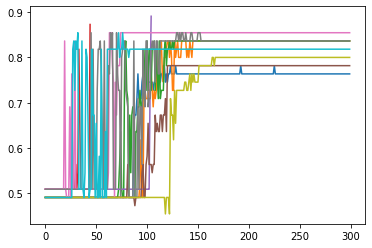

In [108]:
for m in matrices4: print(m)
[plt.plot(hist.history['val_accuracy']) for hist in hists]
[ np.array(hist.history['val_accuracy'][-10:]).mean() for hist in hists ]

### TabNet

[TabNet]: 6 features will be used for decision steps.
[TabNet]: 6 features will be used for decision steps.
[TabNet]: 6 features will be used for decision steps.
[TabNet]: 6 features will be used for decision steps.
[TabNet]: 6 features will be used for decision steps.
Accuracy: 0.5782±0.0233, std: 0.0466, confidence: [0.4483 0.7081]
Specificity: 0.7548±0.0726, std: 0.1451, confidence: [0.6278 0.8819]
Sensitivity: 0.35±0.0899, std: 0.1799, confidence: [0.1919 0.5081]
Positive Precision: 0.5332±0.0436, std: 0.0755, confidence: [0.3155 0.751 ]
Positive Precision: 0.6029±0.0183, std: 0.0366, confidence: [0.4475 0.7582]
Not Severe:  0.2909090909090909
F1-score: 0.5097966928301245


,average,std. error,std. deviation,avg ci lower bound,avg ci upper bound
accuracy,0.578182,0.023284,0.046568,0.448267,0.708097
sensitivity,0.350000,0.089946,0.179892,0.191939,0.508061
positive precision,0.533248,0.043585,0.075491,0.315453,0.751043
negative precision,0.602859,0.018292,0.036585,0.447472,0.758245


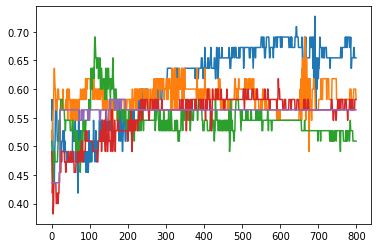

In [77]:
from tabnet import TabNet, TabNetClassifier

def test_tabnet(output_dim = 5, feature_per_dec_step = 6, num_decision_steps = 2, epochs_100 = 8, n_exp = 2):
  hists2 = []
  matrices = []
  # come sopra faccio piu test
  for i in range(n_exp):
    # divido i dati
    (X_train, X_test), (y_train, y_test) = get_split_data(test_size = 1/3, trucchetto = False, filtro_colonne=False)
    
    # modifico le Y per metterle nella forma necessitata dal modello
    y_train_cat = np.array(list(map(lambda yi:[1,0] if yi==-1 else [0,1], y_train))).astype(np.float32)
    y_test_cat = np.array(list(map(lambda yi:[1,0] if yi==-1 else [0,1], y_test))).astype(np.float32)

    # converto il tipo dei dati
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    tabnet_model = TabNetClassifier(
        feature_columns=None, 
        num_classes = 2, 
        num_features = X_train.shape[1],
        feature_dim = output_dim+feature_per_dec_step,
        output_dim = output_dim,
        num_decision_steps = num_decision_steps
    )
    tabnet_model.compile(optimizer=Adam(learning_rate = 0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    
    # addestro il modello
    hist = tabnet_model.fit(
        X_train, y_train_cat, epochs=int(epochs_100*100),
        validation_data=(X_test, y_test_cat),
        verbose = 0
    )
    # e calcolo la matrice di confusione
    matr = get_confusion_matrix(
        y_test,
        np.argmax( # mappa ogni previsione tra 0 e 1 
            tabnet_model.predict(X_test), axis = 1
        ) * 2 - 1 # poi mappa tra 0 e 2, poi tra -1 e 1, per comparare con le y originali
    )
    matrices.append(matr)

    hists2.append(hist)
  return hists2, matrices

h,m = test_tabnet(output_dim = 6, feature_per_dec_step = 6, n_exp=5)
[plt.plot(hist.history['val_accuracy']) for hist in h]
print_confusion_matrices_report(m, False)